## Problem statement:
The purpose of current project is to tain a CNN for segmenting edema in eye OCT images. Edema appears as dark regions within the image.


## Approach:
Data pre-processing and normalization is performed. Then a U-Net CNN is trained on OCT images and ground-truth labels to learn edema detection.


## DATA:
To train the network 1500 2D OCT images with corresponding labels are used. Currently, 90% of data is used for training and the rest for validation. No test set was used in the current work.


## Result:
Final loss and accuracy for the validation set is reported. Also visualization is provided to compared predictions with ground-truth labels. Note since this is an educational example, I did not dive deep into validation but typically dice or jaccard similarity values are calculated on a held-out test set to evaluate generalization of the network.

In [19]:
import os
import time
import cv2
import h5py
import math
import pickle
import queue
import numpy as np
import pandas as pd
import threading
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import misc, ndimage
from sklearn import model_selection, preprocessing, metrics
from sklearn.utils import shuffle
from skimage import transform
from tqdm import tqdm
from keras import backend as K
from keras.losses import binary_crossentropy
import keras.backend.tensorflow_backend as KTF
from keras.regularizers import l2
from keras.models import Model, load_model
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.python.client import device_lib

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [20]:
# Get name of available GPU devices. Use regular tensorflow if you do not have access to a GPU.
tf.test.gpu_device_name()

'/device:GPU:0'

### Load data

In [21]:
# Create CVS file to store name of images - to be used later.

# main directory (within this directory there should be a folder called "data" to include "img" and "label").
base_dir = 'C:\\Users\\User\\Desktop\\edema_segmentation\\'

# oct images
train_folder = base_dir + 'data\\img\\'
files_in_train = sorted(os.listdir(train_folder))
df = pd.DataFrame()
df['images'] = [train_folder + str(x) for x in files_in_train]
df.to_csv('oct.csv', header=None)

# label images
label_folder = base_dir + 'data\\label\\'
files_in_label_folder = sorted(os.listdir(label_folder))
df = pd.DataFrame()
df['labels'] = [label_folder + str(x) for x in files_in_label_folder]
df.to_csv('label.csv', header=None)

In [22]:
# Get list of paths for images from the csv file
import csv
def get_path_csv(folder, csv_file):
    with open(os.path.join(folder, csv_file), 'r') as f:
        reader = csv.reader(f)
        meta_data = list(reader)
        path_list = [item[1] for item in meta_data]
    return path_list
try:
    csvFile.close()
except:
    print("Could not close CSV file")
    
    
# Get list of images and labels
img_path = get_path_csv(base_dir, 'oct.csv')
label_path = get_path_csv(base_dir, 'label.csv')

Could not close CSV file


In [23]:
# Read images, normalize intensity values and store as numpy array.
# Using higher resolution (e.g. 256x256) provides better result but will dramatically increase training time.

# Define size of images
im_height = 128
im_width = 128

imgs = []
for i in img_path:
    img_array = cv2.imread(i, 0)/255
    new_array = cv2.resize(img_array, (im_height, im_width))
    new_array = np.expand_dims(new_array, axis=-1)
    imgs.append(new_array)
    
imgs_np = np.array(imgs, dtype=np.float32)
    
labels = []
for i in label_path:
    label_array = cv2.imread(i, 0)/255
    new_label = cv2.resize(label_array, (im_height, im_width))
    new_label = np.expand_dims(new_label, axis=-1)
    labels.append(new_label)
    
label_np = np.array(labels, dtype=np.float32)

Previous research have shown normalizing intensity values between 0 and 1 improves convergence gradient descent. Also, higher resolution image will improve the result with a cost of larger computation.

In [24]:
# Split data into train and valid. 10% of data (150 images) are used for validation
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(imgs_np, label_np, test_size=0.1, random_state=101)


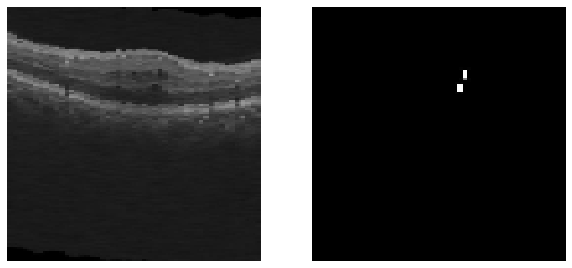

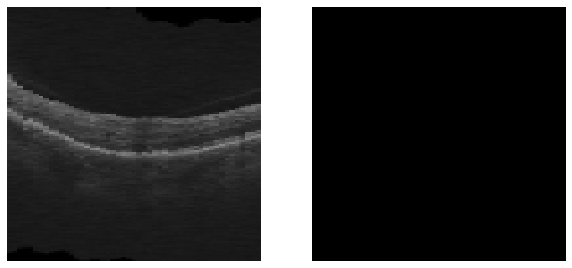

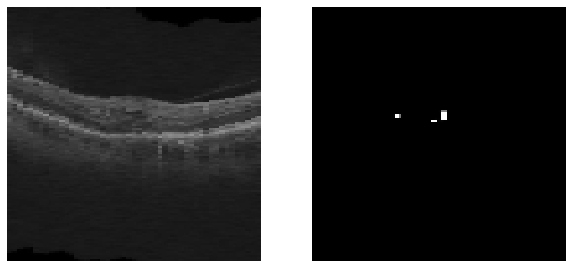

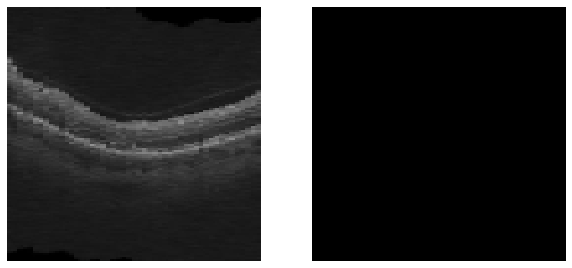

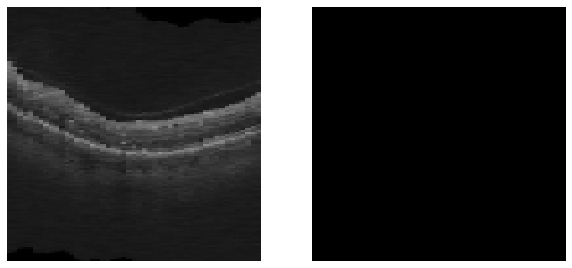

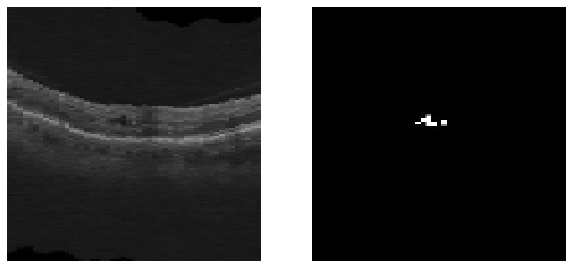

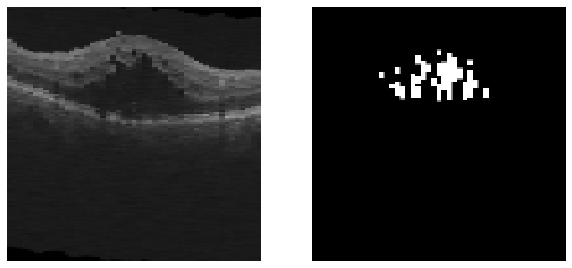

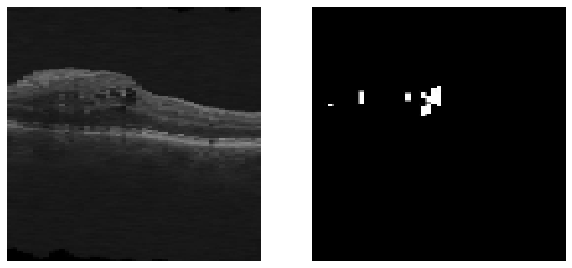

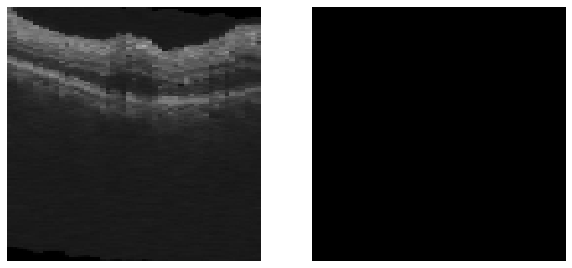

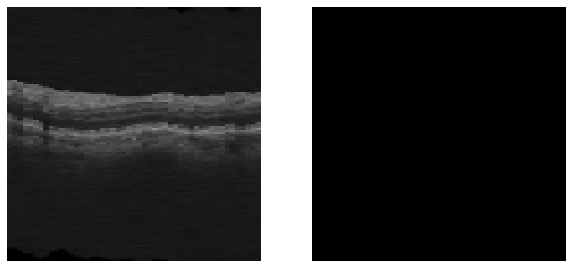

In [25]:
# Visualize  sample data from training set with corresponding ground-truth labels.
for i in range(0, 500, 50):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(X_train[i].squeeze(), cmap='gray', vmin=0.0, vmax=1)
    ax[0].axis('off')
    ax[1].imshow(y_train[i].squeeze(), cmap='gray', vmin=0.0, vmax=1)
    ax[1].axis('off')

### Define UNET network

In [26]:
# Define 2D convolutional block. Use He initialization and padding for convolutional layer with Relu activation.
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               kernel_initializer="he_normal", padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               kernel_initializer="he_normal", padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x

In [27]:
# Define UNET structure
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1,1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [28]:
# Define input shape and dropout rate. Compile the model with Adam optimizer and binary cross entropy cost function.
# Also apply batchnormalization to avoid vanishing gradient.
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=11, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

# Print model summery
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 11) 110         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 128, 128, 11) 44          conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 128, 128, 11) 0           batch_normalization_19[0][0]     
__________________________________________________________________________________________________
conv2d_21 

__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 16, 16, 176)  0           conv2d_transpose_5[0][0]         
                                                                 activation_26[0][0]              
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 16, 16, 176)  0           concatenate_5[0][0]              
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 16, 16, 88)   139480      dropout_13[0][0]                 
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 16, 16, 88)   352         conv2d_30[0][0]                  
__________________________________________________________________________________________________
activation

### Train the model

In [29]:
# define early stop and reduce learning rate if loss does not change for 10 epochs
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [EarlyStopping(patience=10, verbose=1),
             ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.0001, verbose=1),
             ModelCheckpoint('model_oct_edema.h5', verbose=1, save_best_only=True,
             save_weights_only=True)]

In [30]:
# Train the model with back size of 50 for 30 epochs with early stop.
results = model.fit(X_train, y_train, batch_size=50, epochs=30, verbose=2, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 1350 samples, validate on 150 samples
Epoch 1/30
 - 7s - loss: 0.4311 - acc: 0.9336 - val_loss: 0.2766 - val_acc: 0.9847

Epoch 00001: val_loss improved from inf to 0.27662, saving model to model_oct_edema.h5
Epoch 2/30
 - 2s - loss: 0.3069 - acc: 0.9885 - val_loss: 0.2088 - val_acc: 0.9890

Epoch 00002: val_loss improved from 0.27662 to 0.20885, saving model to model_oct_edema.h5
Epoch 3/30
 - 2s - loss: 0.2421 - acc: 0.9891 - val_loss: 0.1676 - val_acc: 0.9891

Epoch 00003: val_loss improved from 0.20885 to 0.16763, saving model to model_oct_edema.h5
Epoch 4/30
 - 2s - loss: 0.1947 - acc: 0.9891 - val_loss: 0.1759 - val_acc: 0.9891

Epoch 00004: val_loss did not improve from 0.16763
Epoch 5/30
 - 2s - loss: 0.1592 - acc: 0.9891 - val_loss: 0.1448 - val_acc: 0.9887

Epoch 00005: val_loss improved from 0.16763 to 0.14480, saving model to model_oct_edema.h5
Epoch 6/30
 - 2s - loss: 0.1364 - acc: 0.9891 - val_loss: 0.1221 - val_acc: 0.9891

Epoch 00006: val_loss improved from 0.

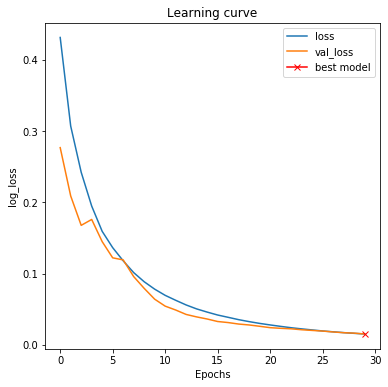

In [31]:
# Plot learning curve and label lowest intersection of training and validation set
plt.figure(figsize=(6, 6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]),
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

The learning curve shows reduce of loss as more epochs are used to train the network. Also the lower intersection point of test and validation lost is marked.

### Save weights

In [32]:
model.save_weights('weights.h5')

With the above command, only weights are saved. To obtain the same result, the model must be defined first, and then weights can be loaded.

### Prediction on validation set

In [33]:
# evaluate model on validation set
model.evaluate(X_valid, y_valid, batch_size=30, verbose=1)

150/150 [==============================] - ETA:  - 0s 487us/step


[0.015313358046114445, 0.992095124721527]

Validation Loss: 0.007 
Validation accuracy: 0.99

In [34]:
# Make prediction image
preds_val = model.predict(X_valid, verbose=0)

In [36]:
# Threshold predictions to get binary label
preds_val_t = (preds_val > 0.6).astype(np.uint8)

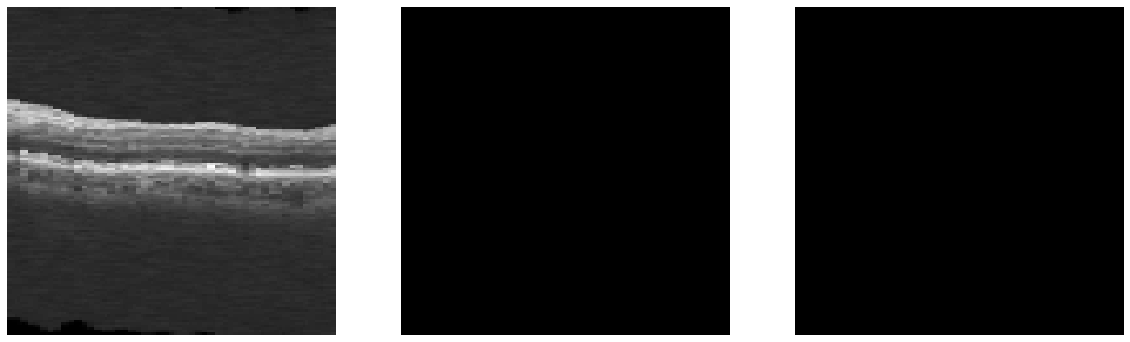

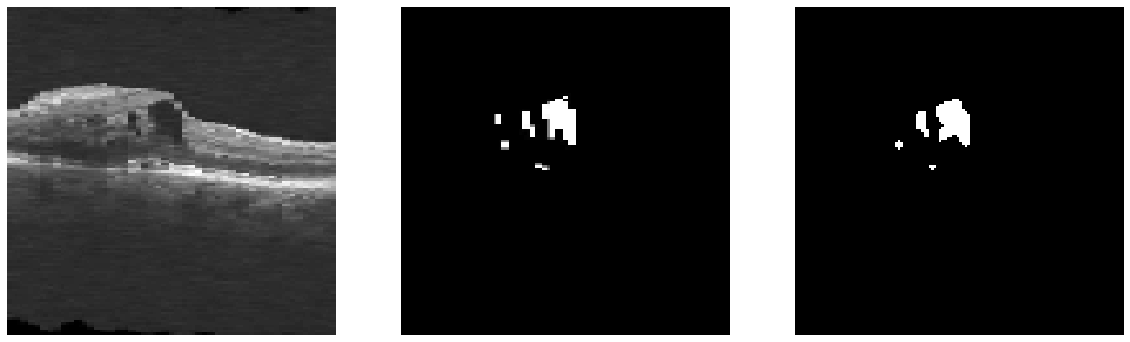

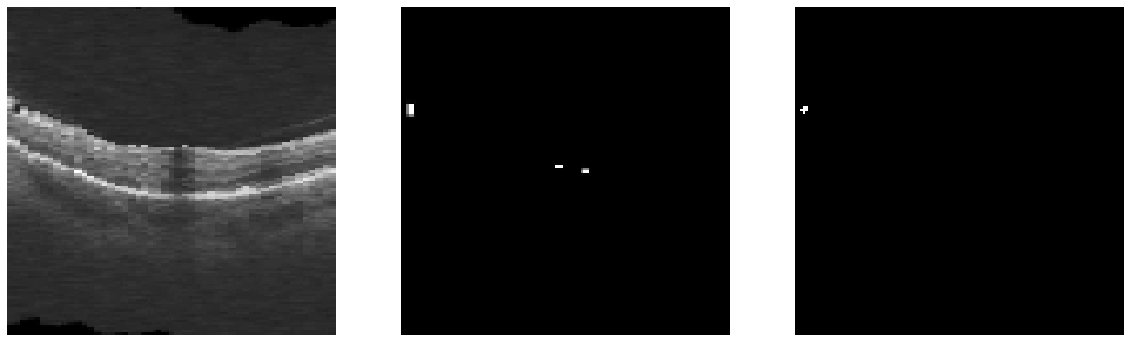

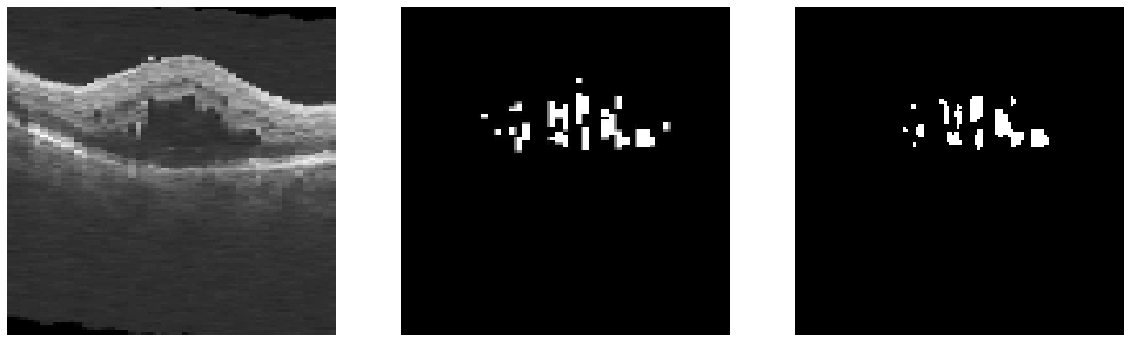

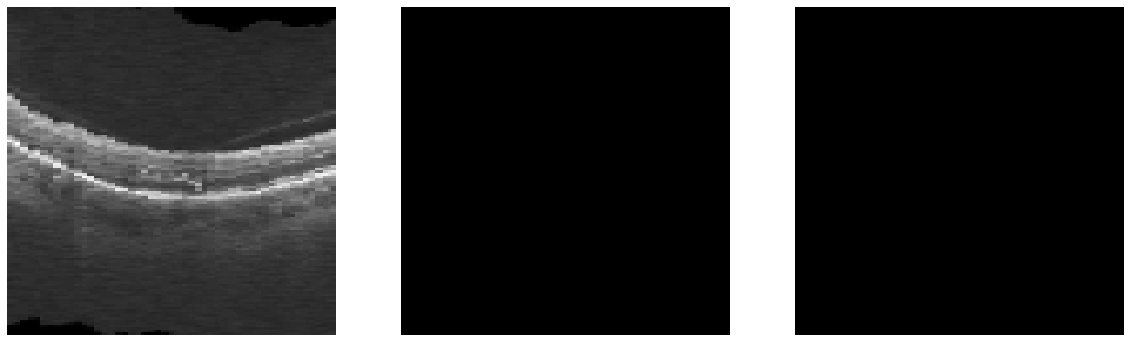

In [38]:
# Visualize sample prediction from validation set
for idx in range(0, 150, 30):
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X_valid[idx].squeeze(), cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(y_valid[idx].squeeze(), cmap='gray')
    ax[1].axis('off')
    ax[2].imshow(preds_val_t[idx].squeeze(), cmap='gray')
    ax[2].axis('off')

The above visualization shows the network is able to identify anomalous areas with good accuracy. It can also be noted lack of false positive in normal appearing images.